In [96]:
# За порамнување на figures
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Големина на figure за да се доволно големи сликите
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [98]:
# Вчитување на листата слики и правење нова листа со самите матрици на сликите
list_image_names = ["images/diamondhead-05.png", "images/diamondhead-06.png", "images/diamondhead-07.png", "images/diamondhead-08.png", "images/diamondhead-09.png", "images/diamondhead-10.png", "images/diamondhead-11.png"]
images = []
for name in list_image_names:
    images.append(cv2.imread(name))

# Параметри
descriptorDetector = "SIFT" # SIFT, ORB
matcherType = "FLANN" # FLANN, BRUTEFORCE
percentageMatches = 0.75 # [0.0, 1.0]
shouldCrop = False # True, False (НАПОМЕНА: оваа опција малку ја деградира точноста на панорамата)

In [99]:
# Функција која спојува 2 слики во панорама, ако имаат доволно слични карактеристики
def stitch(img1, img2, detectortype, matchertype, percentagematches, crop = False):
    
    # За наоѓање на дескрипторите и клучните точки, подобро е процесирање
    # врз монохроматска / црно-бела слика, затоа ги конвертираме сликите.
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Приказ на 2те слики
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16, 9))
    ax1.set_xlabel("Слика 1", fontsize=14)
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax2.set_xlabel("Слика 2", fontsize=14)
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()

    descriptorDetector = None
    k1 = None
    k2 = None
    d1 = None
    d2 = None
    
    # Детекција на дескрипторите и клучните точки на дадените црно-бели слики,
    # со користење на еден од постоечките алгоритми како SIFT, SURT, ORB, etc.
    if detectortype == "SIFT":
        descriptorDetector = cv2.SIFT_create()
        k1, d1 = descriptorDetector.detectAndCompute(img1_gray, None)
        k2, d2 = descriptorDetector.detectAndCompute(img2_gray, None)
    elif detectortype == "ORB":
        descriptorDetector = cv2.ORB_create()
        k1, d1 = descriptorDetector.detectAndCompute(img1_gray, None)
        k2, d2 = descriptorDetector.detectAndCompute(img2_gray, None)

    matcher = None
    
    # Matcher кој (зависно од методот), за дадени 2 листи на дескриптори, ги
    # наоѓа паровите дескриптори од 2те слики кои се доволно слични / исти
    if(matchertype == "BRUTEFORCE"):
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE)
    elif(matchertype == "FLANN"):
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_FLANNBASED)
    matches = matcher.match(d1, d2, None)
    
    # Ги сортираме паровите поклопувања според колку се оддалечени меѓусебе,
    # во однос на аголот, насоката и големината на дескрипторот.
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    # Ги процесираме само најдобрите X проценти
    num_good_matches = int(len(matches) * percentageMatches)
    good_matches = matches[:num_good_matches]

    # За да се создаде хомографија од една на друга рамнина, потребни се најмалку 4 точки.
    if(len(good_matches) < 4):
        print("ERROR! Нема најмалку 4 точки за да се калкулира хомографијата!")

    # Приказ на најдените парови клучни точки кои се доволно слични, на слика
    imMatches = cv2.drawMatches(img1, k1, img2, k2, good_matches, None, flags=2)
    plt.xlabel("Најдени поклопувачки парови", fontsize=14)
    plt.imshow(cv2.cvtColor(imMatches, cv2.COLOR_BGR2RGB))
    plt.show()

    # Локациите на најдобрите парови, како низи точки
    points1 = np.array([k1[match.queryIdx].pt for match in good_matches], dtype=np.float32)
    points1 = points1.reshape((-1, 1, 2))
    points2 = np.array([k2[match.trainIdx].pt for match in good_matches], dtype=np.float32)
    points2 = points2.reshape((-1, 1, 2))

    # Калкулирање на хомографска матрица, односно хомографска трансформација на 2рата слика
    # за да се софпаѓаат најдените парови софпаѓачки клучни точки, според RANSAC алгоритмот
    homography, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

    # Откако ќе ја калкулираме хомографијата, ја аплицираме на втората слика, така што големината
    # на новодобиената слика ќе биде доволна за да ја собере првата и втората слика.
    result2to1 = cv2.warpPerspective(img2, homography, (2*(img1.shape[1] + img2.shape[1]), (img1.shape[0] + img2.shape[0])))
    plt.xlabel("Warped Слика2 според хомографијата", fontsize=14)
    plt.imshow(cv2.cvtColor(result2to1, cv2.COLOR_BGR2RGB))
    plt.show()

    # Едноставна замена на делот на новодобиената warped слика, за да ја вметнеме првата слика
    result2to1[0:img1.shape[0], 0:img1.shape[1]] = img1
    plt.xlabel("Резултатот од сврзување на сликите", fontsize=14)
    plt.imshow(cv2.cvtColor(result2to1, cv2.COLOR_BGR2RGB))
    plt.show()
    
    result = result2to1
    
    if(crop is False):
        # Правиме threshold за да се најдат контурите, за да може да го тргнеме новодобиениот црн дел
        # на крајот на сликата, добиен од хомографската трансформација на втората слика.
        gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        threshold = cv2.threshold(gray_result, 0, 255, cv2.THRESH_BINARY)[1]
        contours, hierarchy = cv2.findContours(threshold.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        res_contours = cv2.drawContours(result.copy(), contours, -1, (0, 255, 255))

        # Приказ на контурите
        plt.xlabel("Најдени контури", fontsize=14)
        plt.imshow(cv2.cvtColor(res_contours, cv2.COLOR_BGR2RGB))
        plt.show()

        # Најди bounding box на контурата која има најголема плоштина, без црниот дел
        contour_maxArea = max(contours, key=cv2.contourArea)
        (x, y, width, height) = cv2.boundingRect(contour_maxArea)
        result = result[y: y + height, x: x + width]
        plt.xlabel("Видлива најголемата контура", fontsize=14)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.show()

        return result
    
    else:
        # Наместо да се гледаат било какви црни региони, ги crop-нуваме само регионите од сликата кои 
        # се целосно обоени. Односно, најголемиот впишан правоаголник во целата слика. 
        # НАПОМЕНА: Овој метод брише дел од сликата кој може да биде искористен за наоѓање клучни точки
        # со понатамошни слики, и поради тоа може да афектира на точноста на најдената хомографија.
        
        gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        gray_result = cv2.medianBlur(gray_result,3) # За шум
        
        # Правиме threshold и ги наоѓаме контурите на сликата
        thresh = cv2.threshold(gray_result,1,255,0)[1]
        contours, h = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        # Ја бараме најголемата контура од сите и правиме апроксимација на неа
        contour_maxArea = max(contours, key=cv2.contourArea)
        approx = cv2.approxPolyDP(contour_maxArea, 0.01 * cv2.arcLength(contour_maxArea, True), True)
        
        # Барање на четирите агли
        far = approx[np.product(approx,2).argmax()][0]
        ymax = approx[approx[:,:,0]==0].max()
        xmax = approx[approx[:,:,1]==0].max()
        x = min(far[0],xmax)
        y = min(far[1],ymax)
        
        # Приказ на резултантниот правоаголник
        result_rect = cv2.rectangle(result.copy(), (1, 1), (x, y), color=(0, 255, 255))
        plt.xlabel("Најмалиот правоаголник впишан во контурата, без празни региони")
        plt.imshow(cv2.cvtColor(result_rect, cv2.COLOR_BGR2RGB))
        plt.show()
        
        # Резултатот ќе биде впишаниот правоаголник
        result = result[:y, :x]
        plt.xlabel("Резултат на спојување на овие две слики")
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.show()
        return result
        

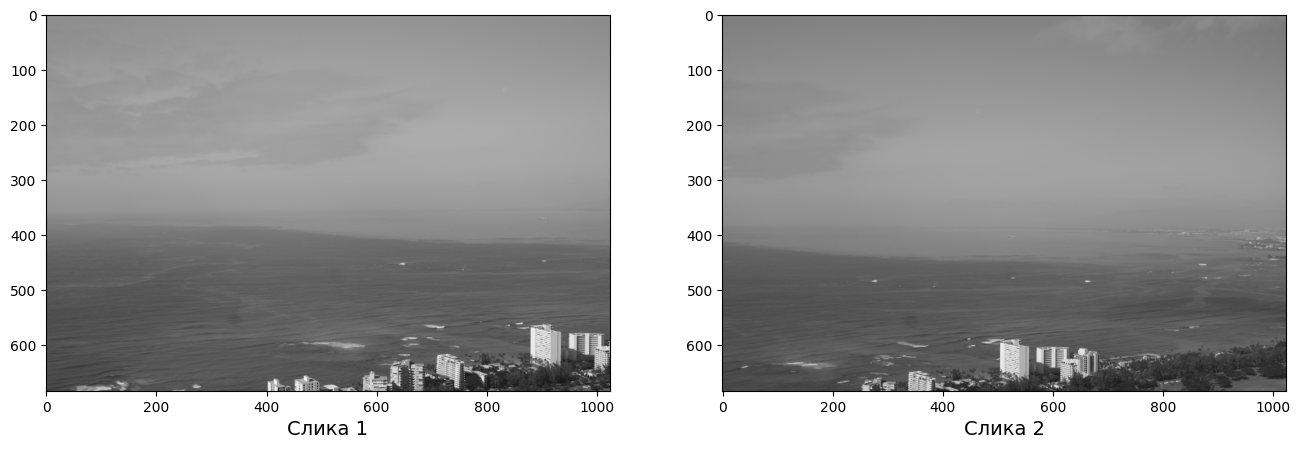

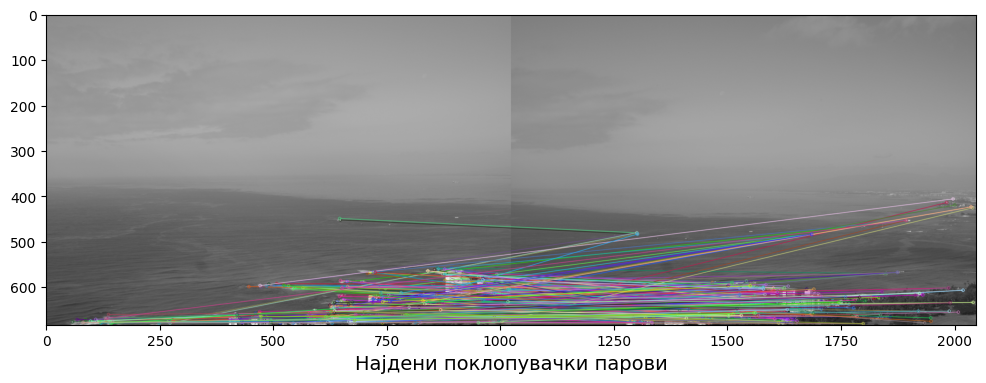

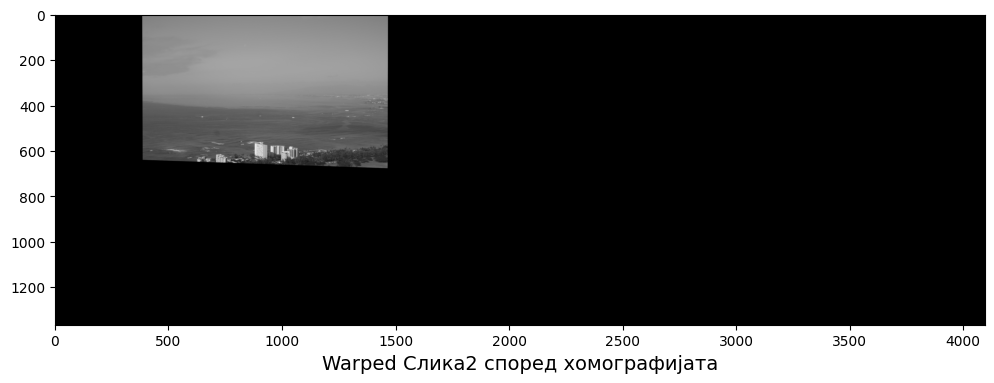

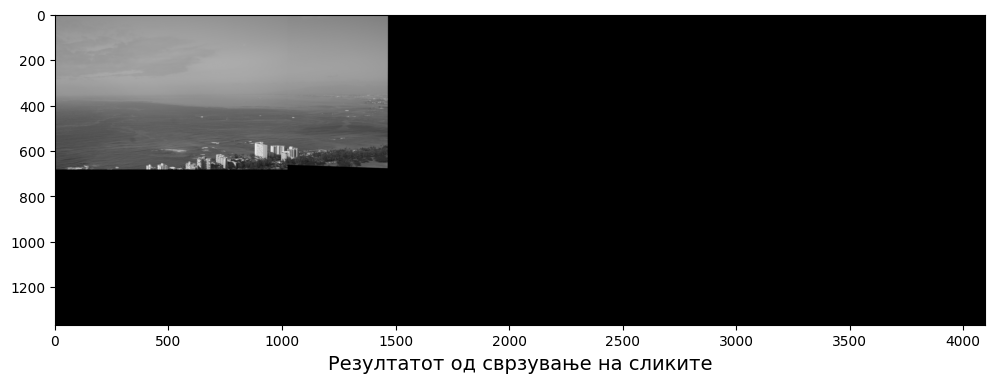

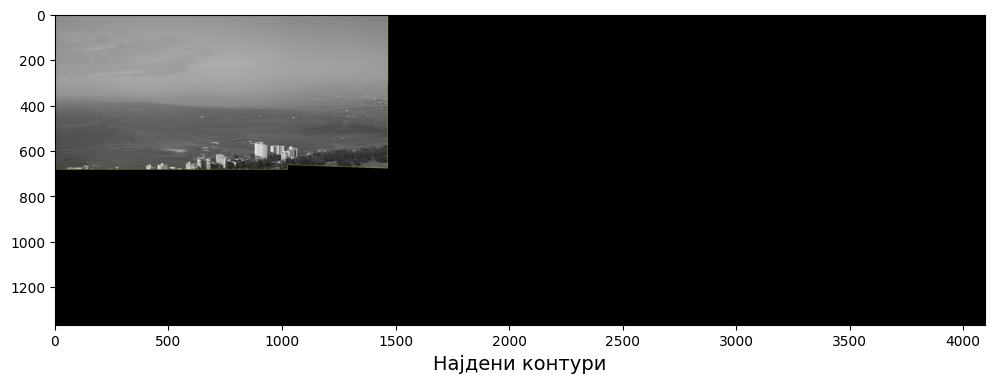

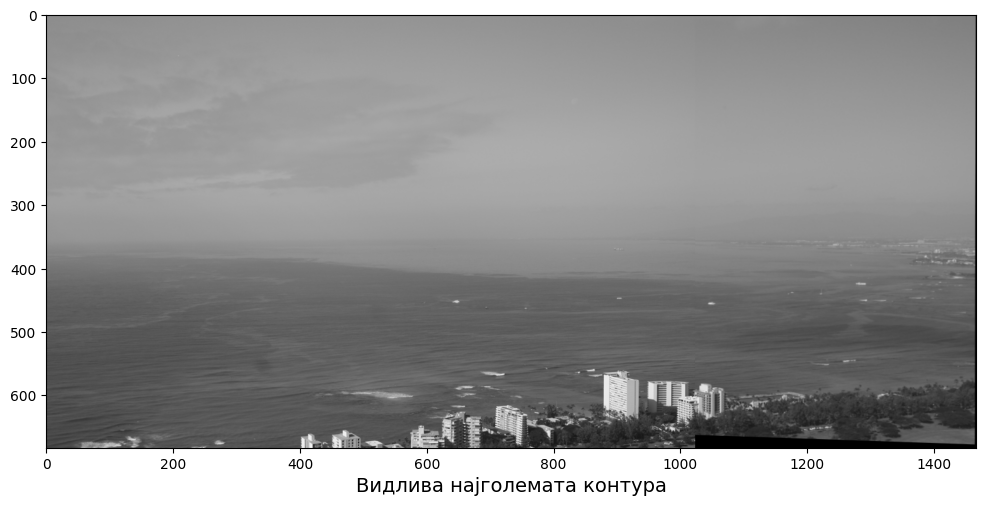

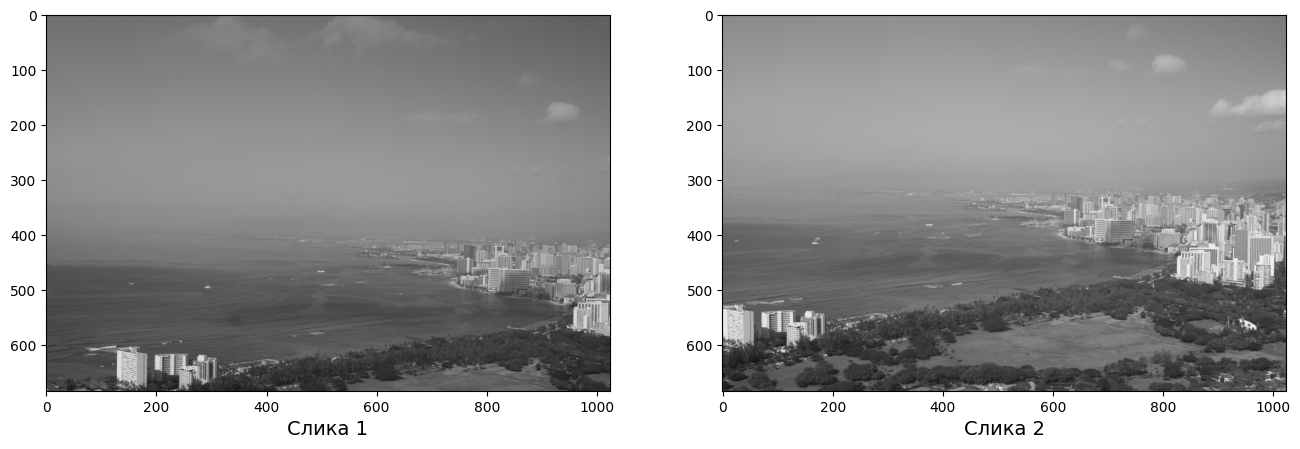

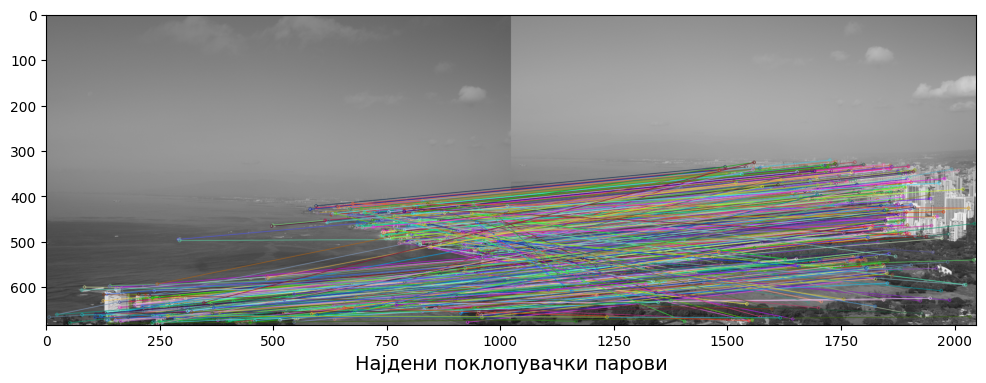

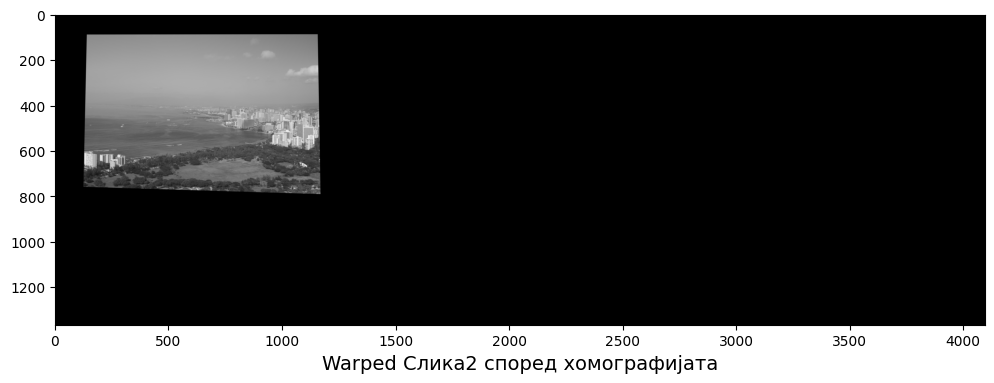

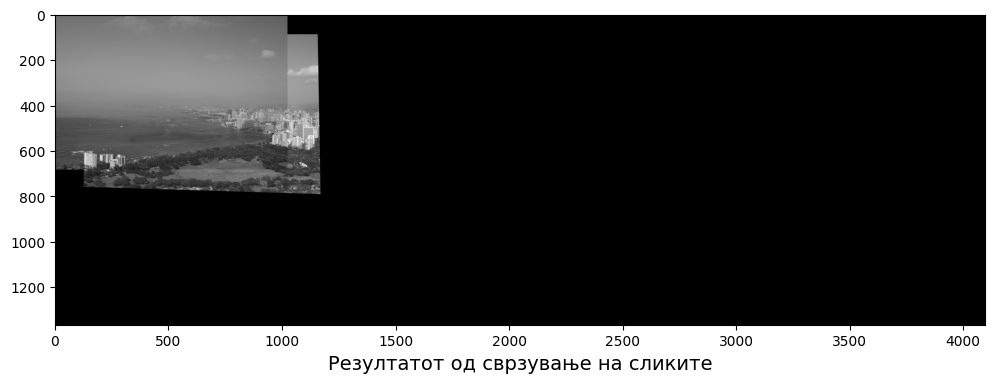

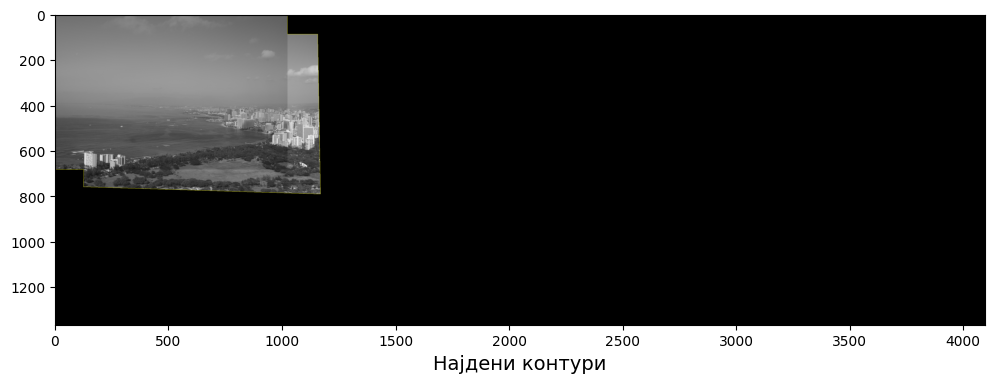

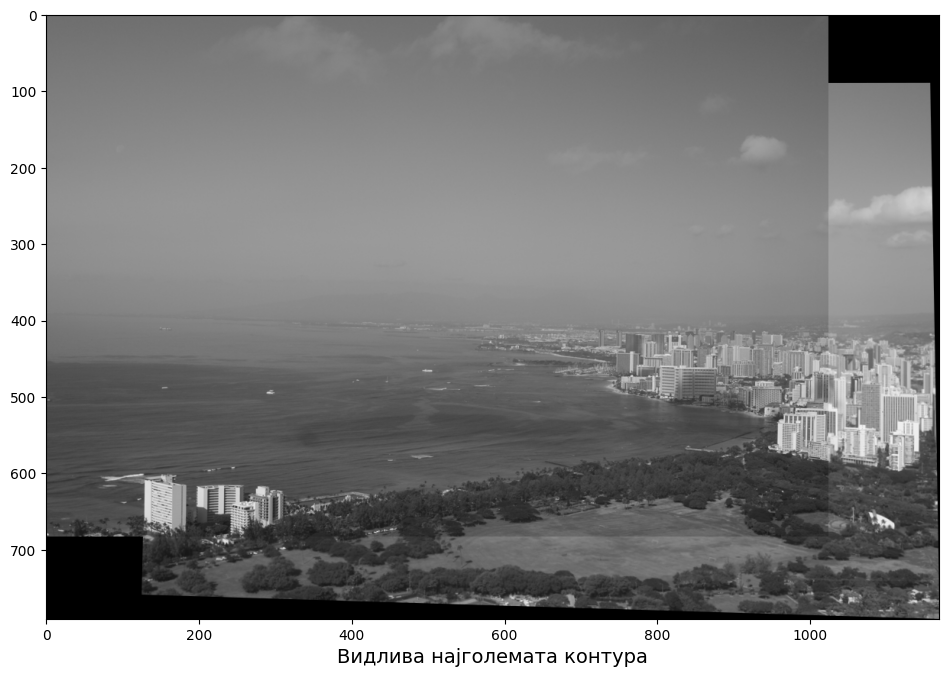

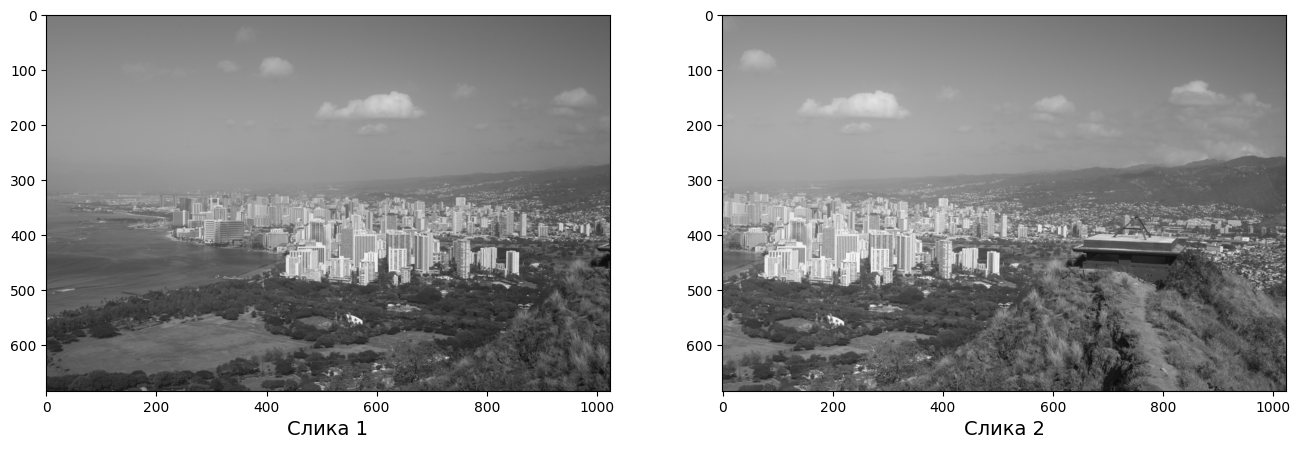

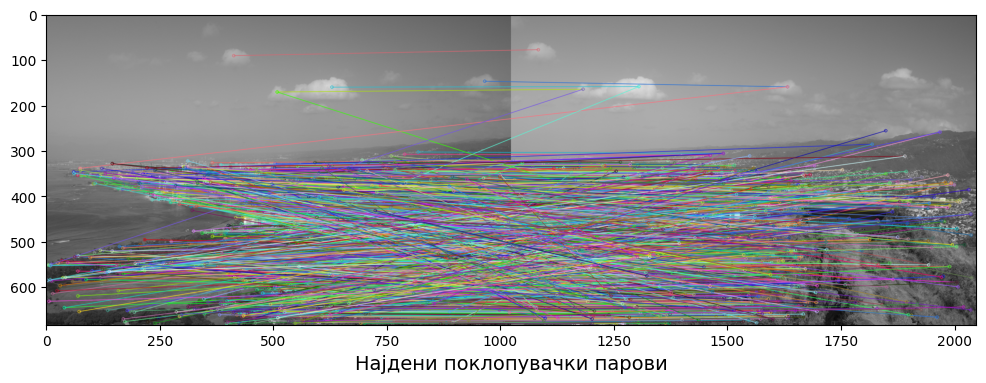

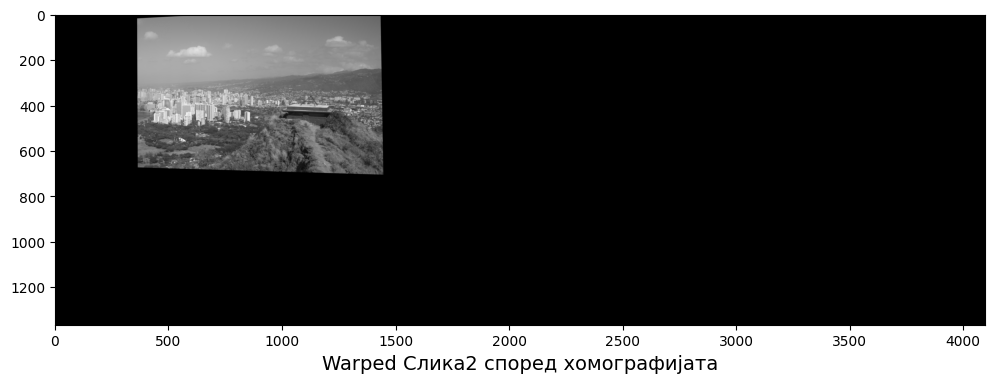

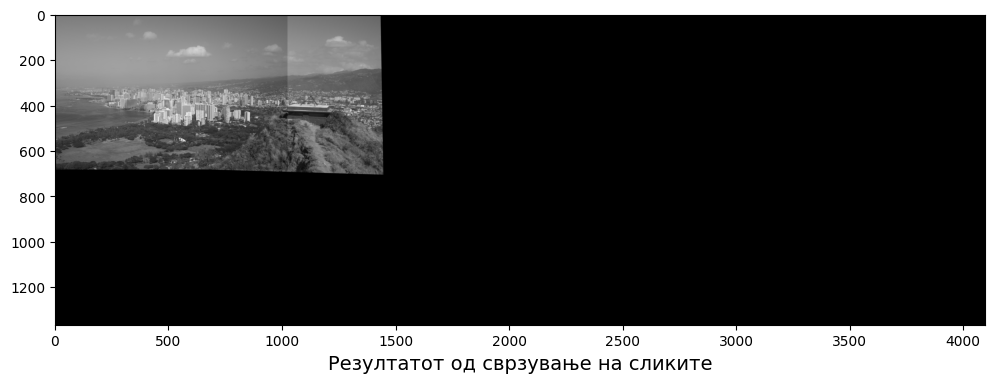

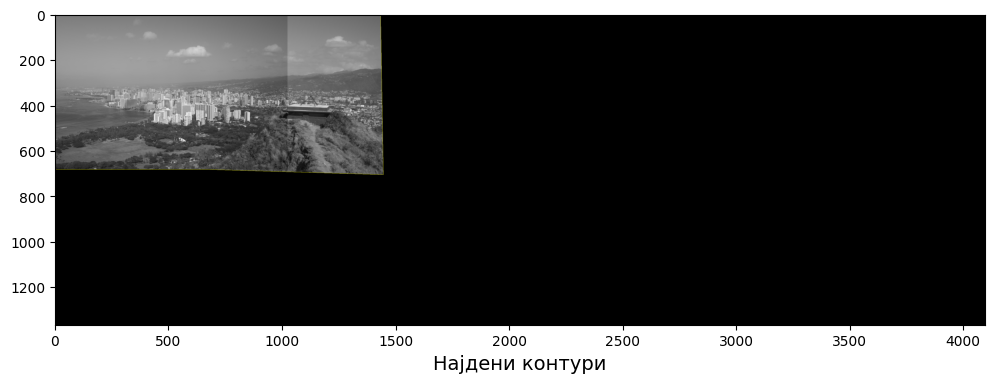

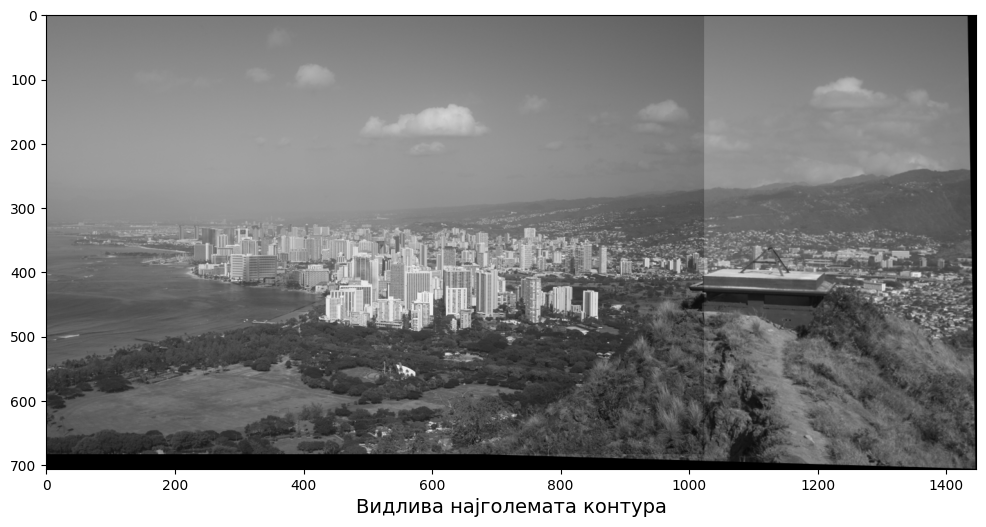

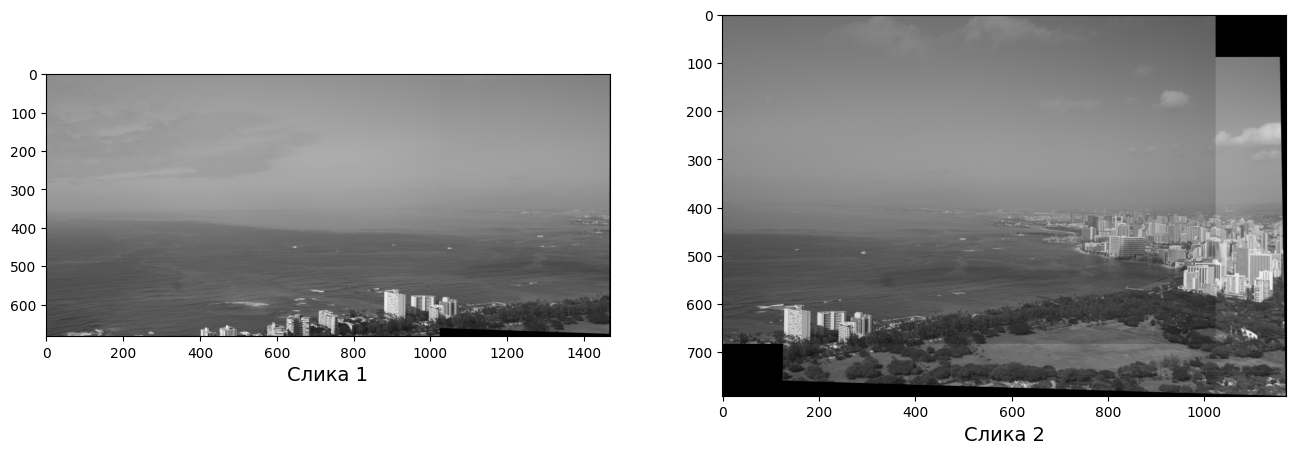

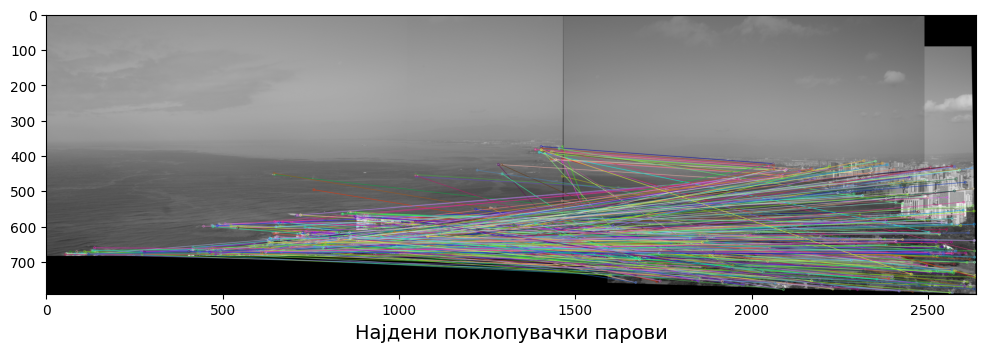

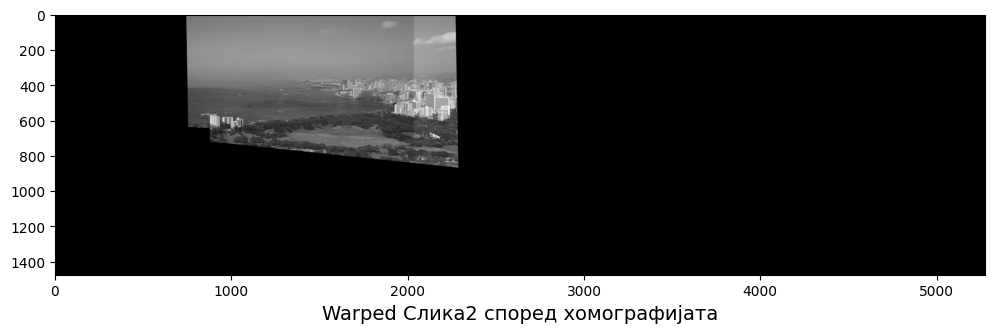

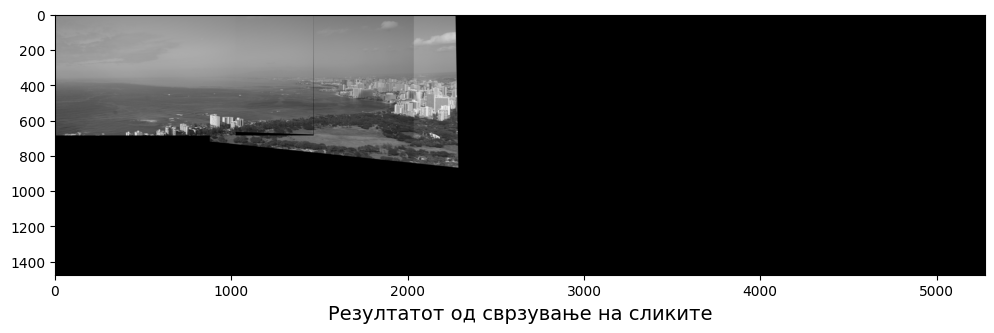

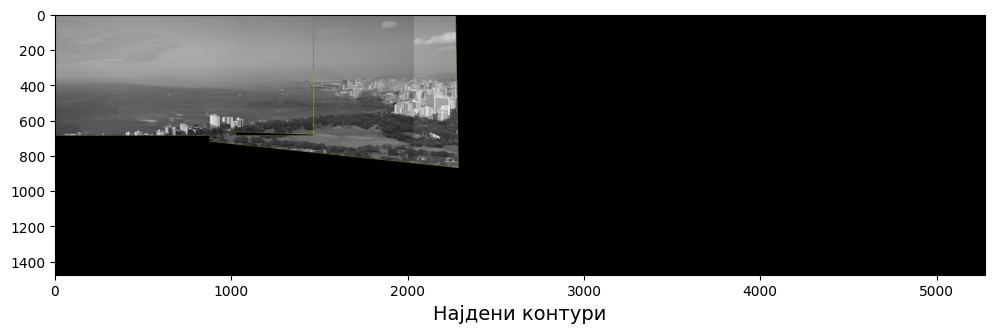

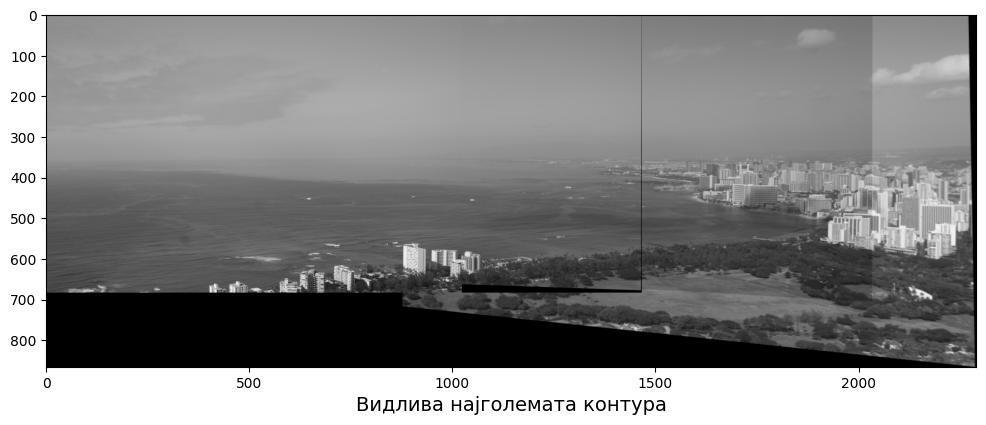

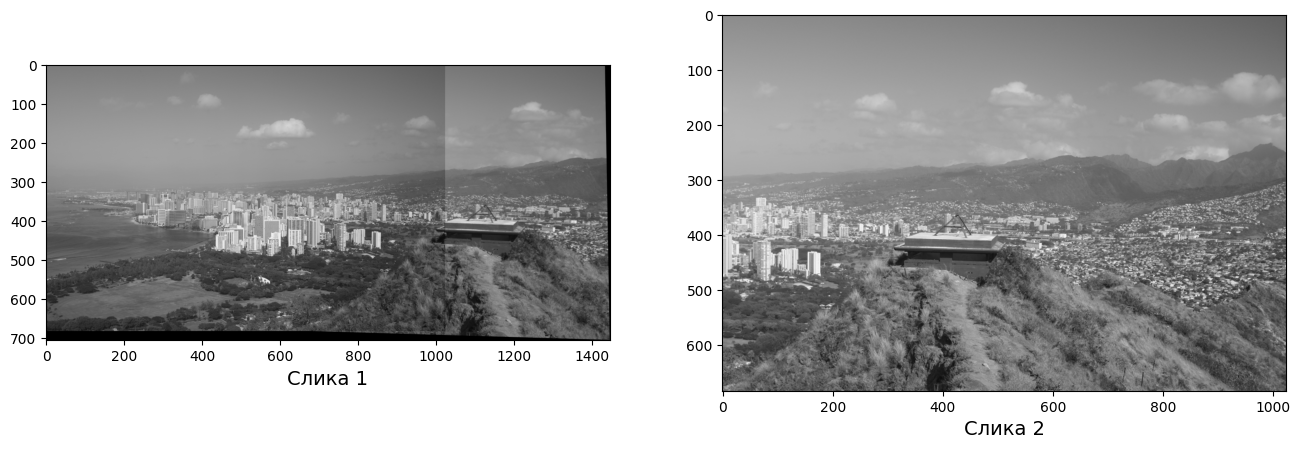

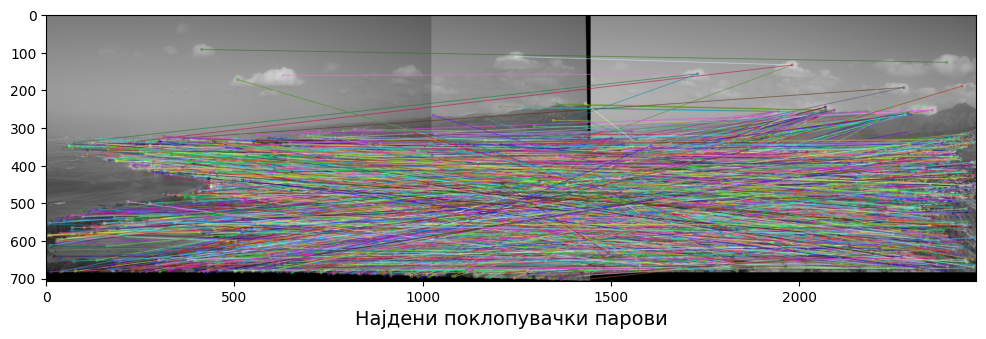

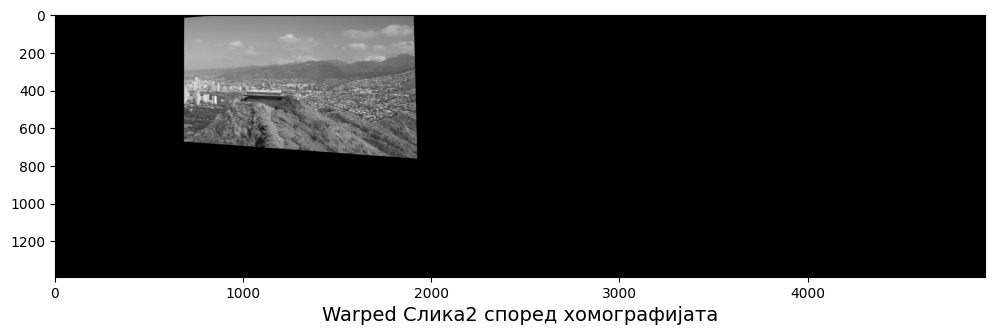

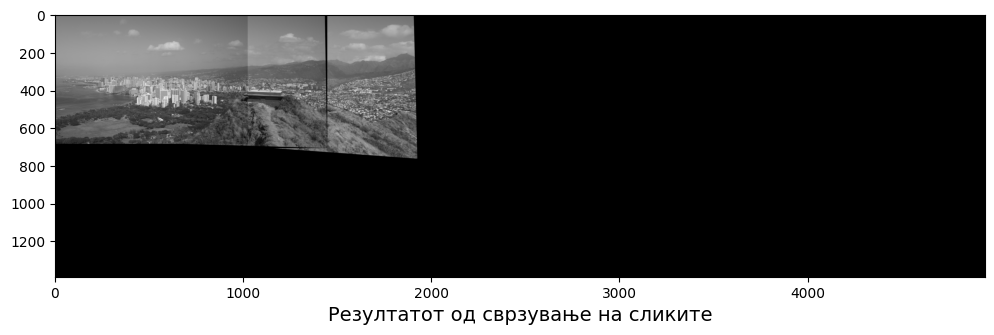

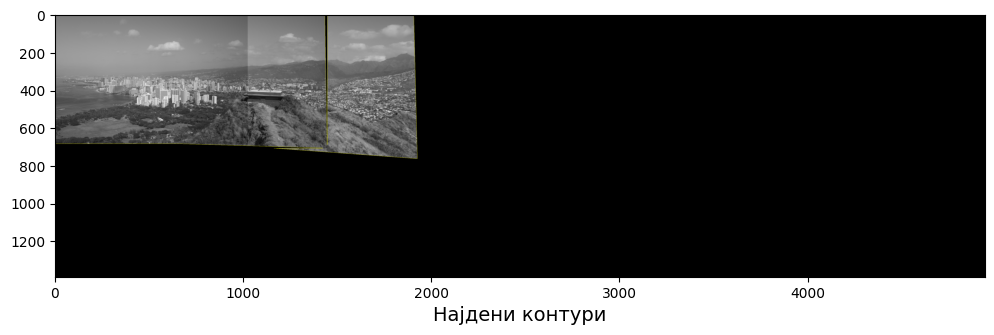

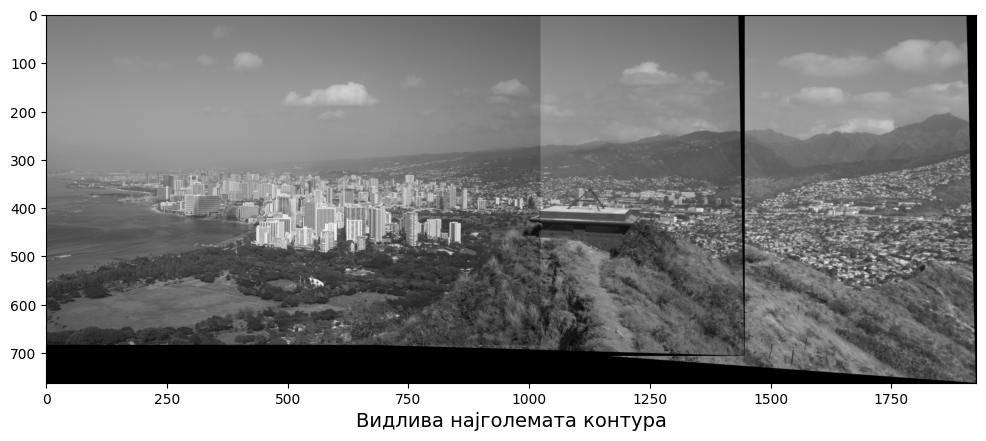

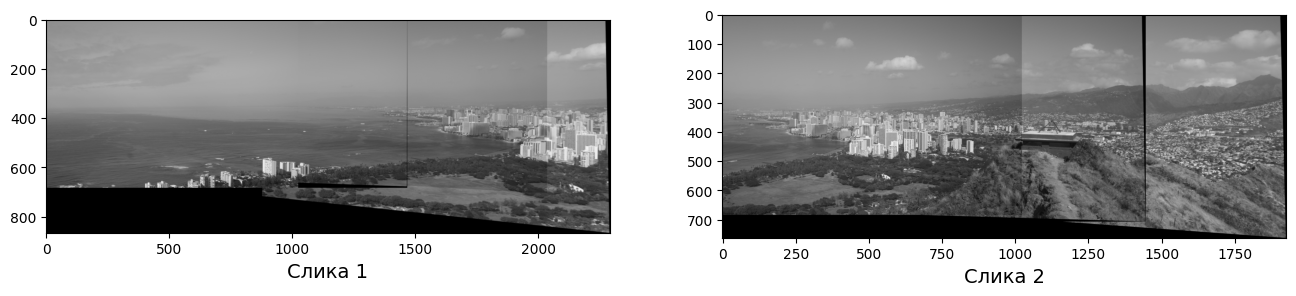

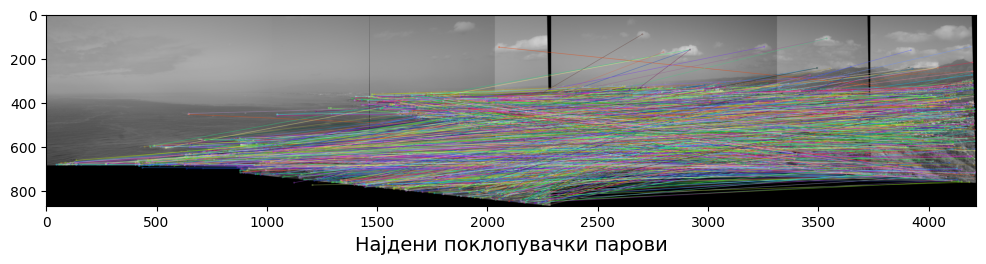

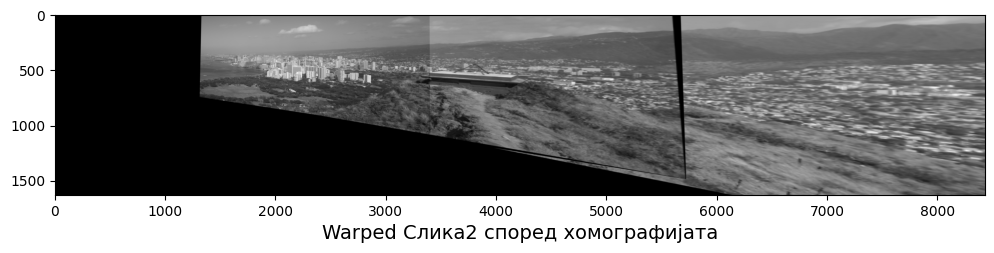

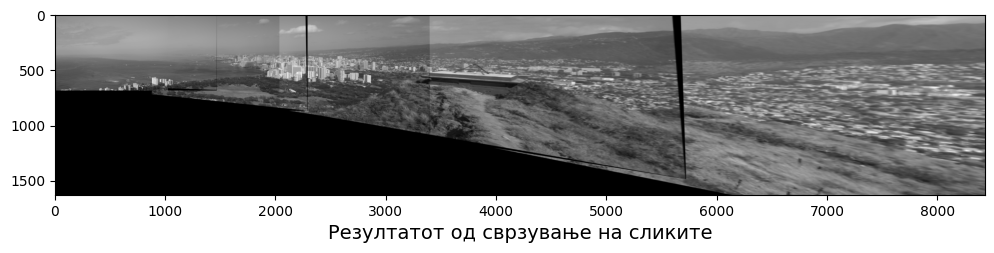

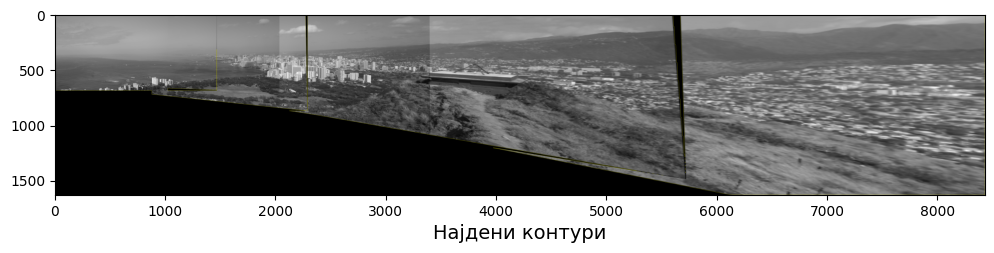

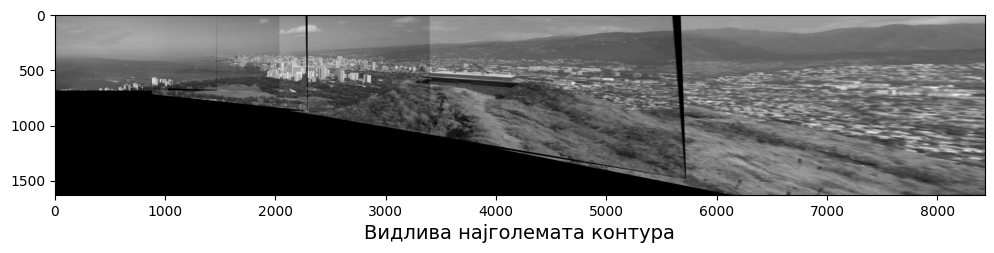

In [100]:
# Ќе се процесираат сликите 2 по 2, прво сите можни парови непроцесирани слики
# па потоа резултатите од тие процесирања, се додека немаме единствена слика во листата
pairwise_stitches = []
while(len(images) > 1):
    while(len(images) >= 2):
        img1 = images[0]
        img2 = images[1]
        stitched = stitch(img1, img2, descriptorDetector, matcherType, percentageMatches, shouldCrop)        
        pairwise_stitches.append(stitched)

        images.remove(img1)
        images.remove(img2)

    if(len(images) == 1):
        pairwise_stitches.append(images.pop())

    images.clear()
    images.extend(pairwise_stitches)
    pairwise_stitches.clear()

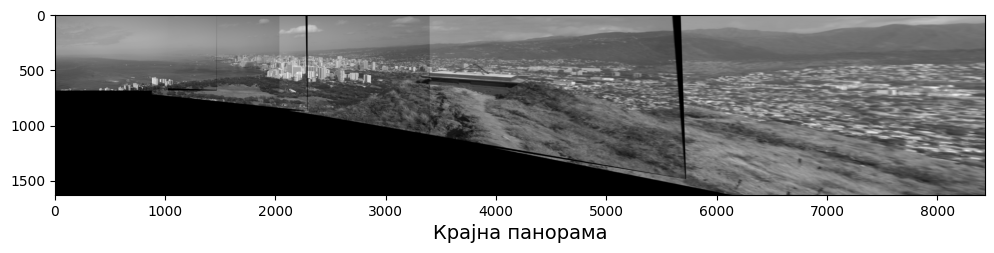

In [101]:
# Приказ на сите слики поврзани во една панорама
result = images[0]
plt.xlabel("Крајна панорама", fontsize=14)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()